## Project 548
You will 
1. Simulate the 2-d quadrotor system
2. Linearize the system
3. Design stabilizing feedback control
4. Design an observer
You are not allowed to use any off-the-shelf tools. You must write your own ODE solvers, LQR implementation, KF implementation, etc. The only exception is that you may use lyap. That is the only exception

In [1]:
%matplotlib inline
#%pdb on
%run _547
np.set_printoptions(precision=2)


# control system model
Consider the simplified quadrotor model
$$m\ddot{h} = u_1\sin\theta,$$
$$m\ddot{v} = -mg + u_1\cos\theta,$$
$$I\ddot{\theta} = u_2$$
where ($h$, $v$) denote the quadrotor (horizontal, vertical) position and $\theta$ denotes the quadrotor's rotation, ($m$, $I$) denote quadrotor (mass, inertia), $g$ is acceleration due to gravity, and ($u_1$, $u_2$) denote the net (thrust, torque) applied by the spinning rotors.

If we measure or observe positions ($h$, $v$), e.g. with GPS, then the control system model is
$$\frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ F((q,\dot{q}),u) \end{array}\right] = f((q,\dot{q}),u),\ y = h(q,\dot{q})$$
where $q = (h,v,\theta)\in\mathbb{R}^3$, $u = (u_1,u_2)\in\mathbb{R}^2$, $F : \mathbb{R}^3 \times \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is defined by 
$$F((q,\dot{q}),u) = \ddot{q} = \left[\begin{array}{c} \frac{u_1}{m}\sin\theta \\ -g + \frac{u_1}{m}\cos\theta \\ \frac{u_2}{I}\end{array}\right],$$ 
and $h : \mathbb{R}^3 \rightarrow \mathbb{R}^2$ is defined by 
$$h(q,\dot{q}) = (h,v).$$

    [1]: http://dx.doi.org/10.1109/ROBOT.2010.5509452

## Part 1. Simulation
#### (a) 
To simulate the quadrotor, first implement Python versions of the ODE control system model; that is create two functions, one for $f$ and one for $h$, that take $t$, $u$, $x$ as arguments and return the dynamics $f(t,x,u)$ and the observation $h(t,x,u)$ respectively 

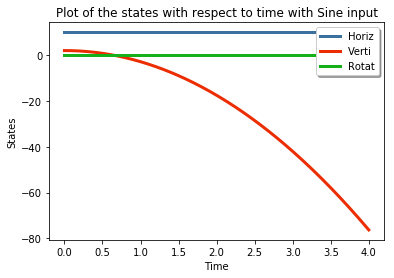

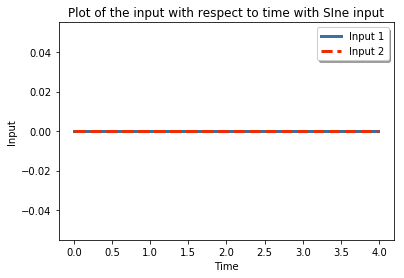

In [2]:
from _547 import forward_euler
import matplotlib.pyplot as plt
import math
import numpy as np
from seaborn import xkcd_rgb as xkcd
from matplotlib import animation, rc
from numpy import linalg as LA
import control
import scipy
import copy
g,m,I = 9.81,1.,1. # m/sec^2, kg, kg m^2

def f(t,x,u):
    # positions, velocities
    # horiz., vert., rotation
    # thrust, torque
    vector= np.asarray([x[3],x[4],x[5],(u[0]/m)*math.sin(x[2]),(-g+(u[0]/m)*math.cos(x[2])),u[1]/I])
    return vector# returning the vecotr of the functions given in the question
def u(t):# function of initial inputs
    return [0,0]

def h(t,x,u):
    # positions, velocities
    # horiz., vert., rotation
    return x[0],x[1]# horizontal, vertical position

def simulate(t):
    t0,x0,t,dt=0,np.array([10,2,0,0,0,0]),t,0.01# defining initial conditions
    T,x,uout= forward_euler(f,t,x0,t0,dt,u,return_u=True)# using forward euler
    cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]# intersting colors
    # plotting the states
    fig, ax = plt.subplots()
    ax.plot(T,x[:,0],c=cols[0],label='Horiz',linewidth=3)
    ax.plot(T,x[:,1],c=cols[1],label='Verti',linewidth=3)
    ax.plot(T,x[:,2],c=cols[2],label='Rotat',linewidth=3)
    legend = ax.legend(loc='upper right', shadow=True)
    plt.title('Plot of the states with respect to time with Sine input')
    plt.xlabel('Time')
    plt.ylabel('States')
    plt.show()
    #Plotting the inputs
    cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]# intersting colors
    fig, ax = plt.subplots()
    ax.plot(T[0:int(t/dt)],uout[:,0],c=cols[0],label='Input 1',linewidth=3)
    ax.plot(T[0:int(t/dt)],uout[:,1],'--',c=cols[1],label='Input 2',linewidth=3)
    plt.title('Plot of the input with respect to time with SIne input')
    plt.xlabel('Time')
    plt.ylabel('Input')
    legend = ax.legend(loc='upper right', shadow=True)
    plt.show()
    
    
    return T,x

T,x=simulate(4)


#### (b) 
What is the equilibrium when $u=(mg, 0)$ (i.e. zero torque and thrust is $mg$)? 

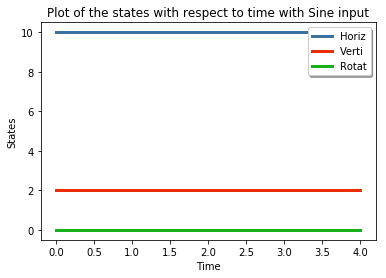

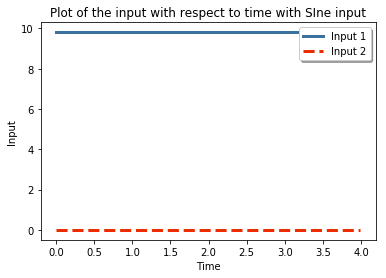

In [3]:
def u(t):
    return [m*g,0]
T,x=simulate(4)

#### (c) 
Simulate the result of applying a sinusoidal thrust of the form
$$u(t)=\begin{bmatrix} mg+\sin(2t\pi\omega)\\ 0\end{bmatrix}$$
and plot the position ($h$,$v$,$\theta$), velocity ($\dot{h}$, $\dot{v}$, $\dot{\theta}$) and input $(u_1,u_2)$ in three seperate plots. I strongly suggest you animate the quadrotor as it will help you visualize the results and better understand what is happening. 

Explore different sinudoidal thrusts and comment on what you observe. That is, choose different frequencies $\omega$ and final simulation times. To start, try a frequency of one cycle every two seconds and a final time of two periods. What do you notice about the quadrotors behavior as you vary these aspects?

Note you need to choose an appropriate initial conditions $(q(0), \dot{q}(0))$, step size $\alpha$ for your trajectory simulation, time horizon $T$, etc. 

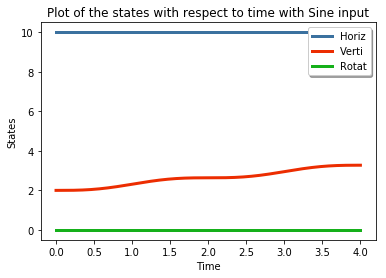

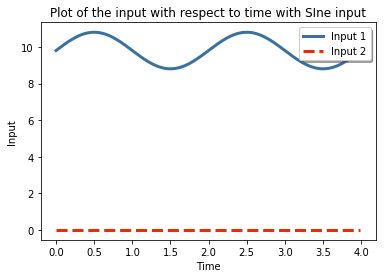

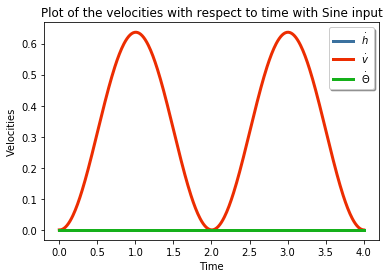

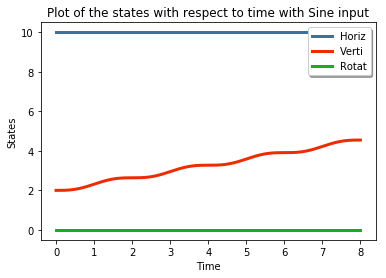

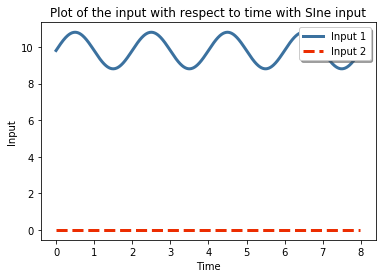

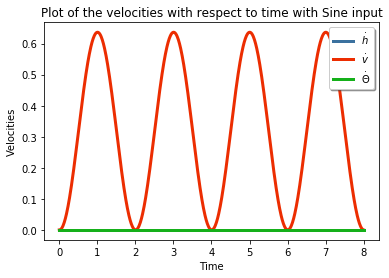

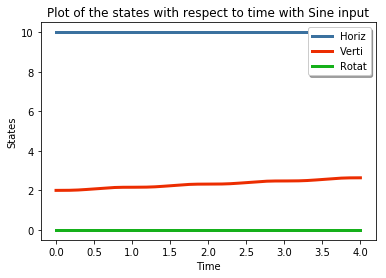

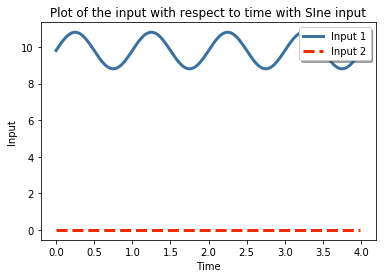

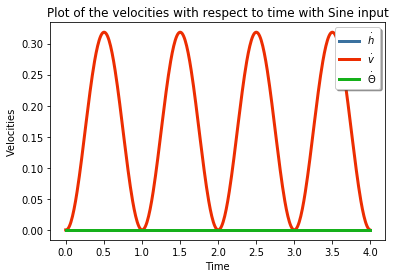

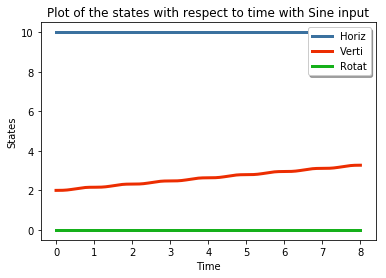

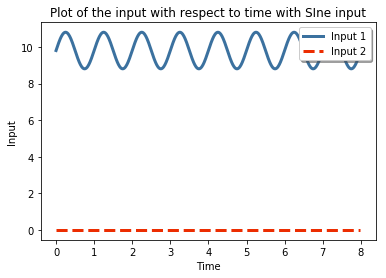

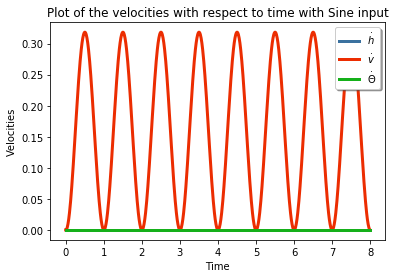

In [4]:
freq= [0.5,1]
time= [4,8]
for w in freq:
    for t in time:
        def u(t):
            return [m*g+ math.sin(2*t*math.pi*w),0]
        T,x= simulate(t)
        fig, ax = plt.subplots()
        cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]# intersting colors
        ax.plot(T,x[:,3],c=cols[0],label='$\dot{h}$',linewidth=3)
        ax.plot(T,x[:,4],c=cols[1],label='$\dot{v}$',linewidth=3)
        ax.plot(T,x[:,5],c=cols[2],label='$\dot{\Theta}$',linewidth=3)
        legend = ax.legend(loc='upper right', shadow=True)
        plt.title('Plot of the velocities with respect to time with Sine input')
        plt.xlabel('Time')
        plt.ylabel('Velocities')
        plt.show()

If you want to implement the animation I provided, use this code below.

In [5]:
# %run _anim
# fig, ax = plt.subplots(figsize=(4,4)); ax.axis('equal'); ax.grid('on');
# line= ax.plot(T, x[:,3], 'b', lw=2);

# plt.close(fig)

# # call the animator
# animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
#                         frames=np.arange(0.,t_[-1],.1), interval=20, blit=True)

## Part 2. Stabilization 
In order to stabilize the system, first linearize it. 

#### (a)
Linearize about the point 
$$ \begin{bmatrix}q\\ \dot{q}\end{bmatrix}=\begin{bmatrix}0\\0.1\\0\\0\\0\\0\end{bmatrix}$$ 
and $u=(mg,0)$
Provide a full mathematical derivation of your linearization. Thinking back to part 1.a, why is it reasonable to linearize about this point?

In [6]:
def f_lin(t,x,u): #function if linearized dynamics
    A=np.asarray([[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[0,0,m*g,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
    B=np.asarray([[0,0],[0,0],[0,0],[0,0],[1/m,0],[0,1/I]])
    return np.dot(A,x)+np.dot(B,u)



#### (b) 
Is the linearized system controllable? Provide justification.
That is, use a controllability test.

In [7]:
def check_ctrb(A,B):#controllability check.
    n,m=A.shape
    l,q=B.shape
    if n!=m or l!=n:
        print('wrong shape!')
        return 0
    ctrb=B
    for i in range(0,n-1):
        temp=np.dot(LA.matrix_power(A,i+1),B)
        ctrb= np.concatenate((ctrb,temp),axis=1)
    #checking with the inbuilt function
    #ctrbchk=control.ctrb(A,B)
    #if (ctrbchk==ctrb).all:
        #return 0
    #return ctrbchk,ctrb
    #checking the rank
    rank=LA.matrix_rank(ctrb)
    r,c=ctrb.shape
    if rank==r:
        print("Full row rank matrix-> Controllable")
        return 1
    return 0
    
x1,u=np.array([0,0.1,0,0,0,0]),[m*g,0]
A=np.asarray([[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[0,0,u[0]/m,0,0,0],[0,0,0,-u[0]/m*x1[2],0,0],[0,0,0,0,0,0]])
B=np.asarray([[0,0],[0,0],[0,0],[x1[2]/m,0],[1/m,0],[0,1/I]])
status=check_ctrb(A,B)
print(LA.eigvals(A))

Full row rank matrix-> Controllable
[ 0.  0.  0.  0.  0.  0.]


#### (c)
Design a stabilizing state feedback control law using Lyapunov. 

1. First, show that if $(A,B)$ is controllable so is $(-\lambda I-A,B)$ for every $\lambda\in \mathbb{R}$.
2. Choose $\lambda$ sufficiently large so that $-\lambda I-A$ is stable. Starting with 
$$P(A-BK)+(A-BK)^TP+2\lambda P=0, \ \ K=\frac{1}{2}B^TP$$
use the Lyapunov stability theorem to show that you can solve
$$(-\lambda I-A)W+W(-\lambda I-A)^T+BB^T=0$$
to find a $K$ that stabilizes the system.
3. Numerically design $K$ using the above analysis. And provide a check that the closed loop system is stable (that is, check the eigenvalues).


In [8]:
def find_k(A,B):    
    la=1
    n,m= A.shape
    newA= -la*np.identity(n)-A
    # check if stable
 
    status= check_ctrb(newA,B)
    if status==1:
        #print(newA)
        #print(B)
        W= np.array(scipy.linalg.solve_lyapunov(newA,np.dot(B,np.transpose(B))))
        #print(W)
        P=LA.inv(W)
        #print(P)
        K= -1/2*np.dot(np.transpose(B),P)
        p,r=K.shape
        Kvalue=np.zeros((p,r))
        for i in range(p):
            for j in range(r):
                Kvalue[i,j]= float(K[i,j])
        return Kvalue,newA
                     
if status == 1: #if its the controllable
    K,newA= find_k(A,B)
    print(K)
    NewA= A-np.dot(B,K)
    E=np.real(LA.eigvals(NewA))
    
    if np.all(E<0):
        print('system is stable')
        

Full row rank matrix-> Controllable
[[ -0.     2.    -0.    -0.     2.    -0.  ]
 [  0.82  -0.    12.     1.63  -0.     4.  ]]
system is stable


# (d) 
Simulate the nonlinear closed loop system using the designed stabilizing feedback control 
for a random initializaton in the neighborhood of the point $(x_0,u_0)$ around which you linearized the system. 
1. That is, you should perturb $x_0$ and use that as your initilization and apply the designed control input to the nonlinear system in a neighborhood of the linearization point. 
2. Try a few different initilizations and describe what you see.  
3. As before, plot the position ($h$,$v$,$\theta$), velocity ($\dot{h}$, $\dot{v}$, $\dot{\theta}$) and input $(u_1,u_2)$ in three seperate plots. Animation will help you visualize what is happening.

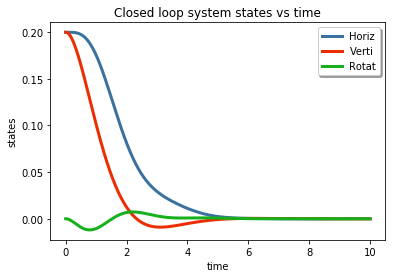

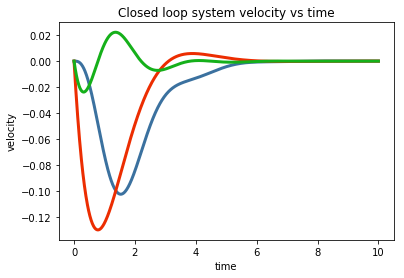

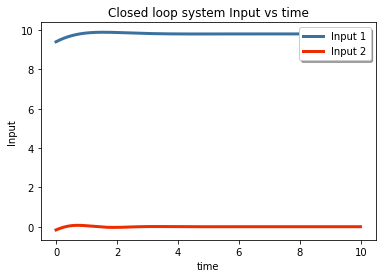

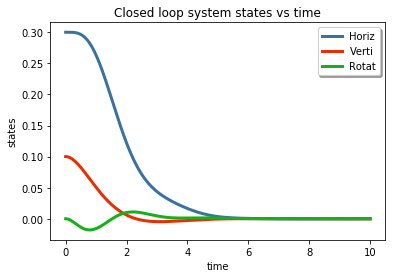

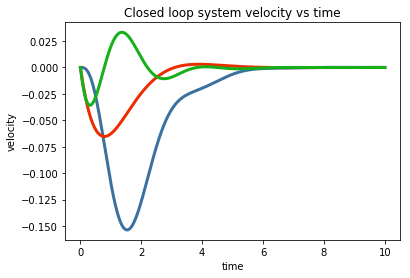

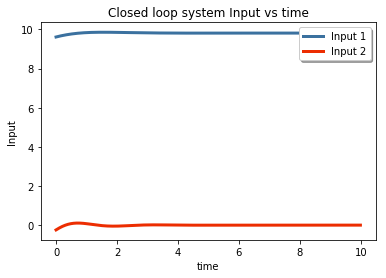

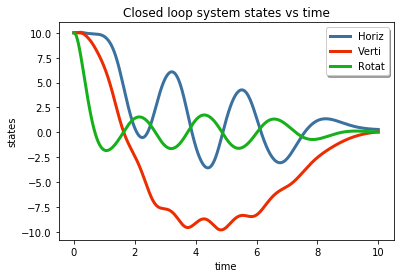

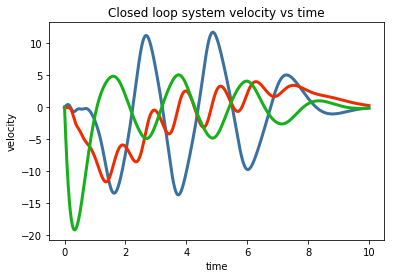

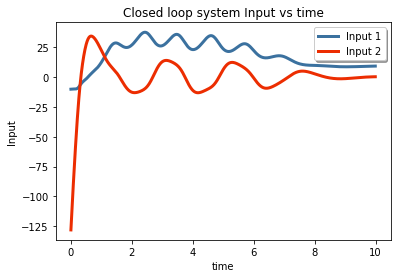

In [9]:
def u(x):
    s=np.dot(-K,x)
    return s+[m*g,0]
def simulatex(x0):
    t0,t,dt=0,10,0.01
    T,x,uout= forward_euler(f,t,x0,t0,dt,ux=u,return_u=True)
    cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]
    
    fig, ax = plt.subplots()
    ax.plot(T,x[:,0],c=cols[0],label='Horiz',linewidth=3)
    ax.plot(T,x[:,1],c=cols[1],label='Verti',linewidth=3)
    ax.plot(T,x[:,2],c=cols[2],label='Rotat',linewidth=3)
    plt.title('Closed loop system states vs time')
    plt.xlabel('time')
    plt.ylabel('states')
    legend = ax.legend(loc='upper right', shadow=True)
    plt.show()
    
    fig, ax2 = plt.subplots()
    ax2.plot(T,x[:,3],c=cols[0],label='Horiz',linewidth=3)
    ax2.plot(T,x[:,4],c=cols[1],label='Verti',linewidth=3)
    ax2.plot(T,x[:,5],c=cols[2],label='Rotat',linewidth=3)
    plt.title('Closed loop system velocity vs time')
    plt.xlabel('time')
    plt.ylabel('velocity')
    plt.show()

    fig, ax3 = plt.subplots()
    ax3.plot(T[0:1000],uout[:,0],c=cols[0],label='Input 1',linewidth=3)
    ax3.plot(T[0:1000],uout[:,1],c=cols[1],label='Input 2',linewidth=3)
    plt.title('Closed loop system Input vs time')
    plt.xlabel('time')
    plt.ylabel('Input')
    
    legend = ax3.legend(loc='upper right', shadow=True)
    plt.show()
    return T,x
# def forwardeuler(t0,t,f,x0,dt,u):
#     steps= np.arange(t0,t,dt)
#     n=x0.shape
#     xout=[]
#     #xout= np.zeros((int(n[0]),int(t/dt)))
#     for i in steps:
#         #print(x0,u)]
#         #print(K,'u',u)
#         u=np.dot(-K,x0)
#         out= x0 + dt*f(i,x0,u)
#         xout.append(out)
#         x0=out
#         #print(out)
#     return steps, xout
# t0,x0,t,dt,u=0,np.array([0.1,0.1,0.1,0.1,0.1,0.2]),5,0.01,[0,0]
# tout,xout= forwardeuler(t0,t,f,x0,dt,u)
# cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]
# fig, ax = plt.subplots()
# arrayx=np.array(xout)
# ax.plot(tout,arrayx[:,0],c=cols[0],label='Horiz',linewidth=1)
# ax.plot(tout,arrayx[:,1],c=cols[1],label='Verti',linewidth=3)
# ax.plot(tout,arrayx[:,2],c=cols[2],label='Rotat',linewidth=3)
# legend = ax.legend(loc='upper right', shadow=True)
# plt.show()
x0=np.array([0.2,0.2,0,0,0,0])
T,x=simulatex(x0)
x0=np.array([0.3,0.1,0,0,0,0])
T,x=simulatex(x0)
x0=np.array([10,10,10,0,0,0])
T,x=simulatex(x0)

## Part 3. Continuous Time LQR Design
In this part you will design an LQR controller. 

#### (a) 
1. Write a function to randomly generate positive semidefinite matrices. (hint: look at _547.py it should be in there already)

2. Write your own numerical scheme to solve LQR. That is, you will need to write your own script to numerically solve the Riccati recursion. 

Hint: write a function to vectorize your matrix differential equation and use the forward_euler implementation you already are using for simulating systems. You can check that you have the correct answer by comparing to an lqr solver, but you have to implement your own method for solving lqr. You CANNOT just use an off-the-shelf tool.


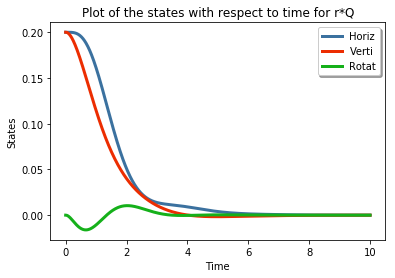

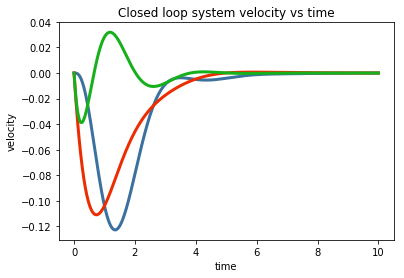

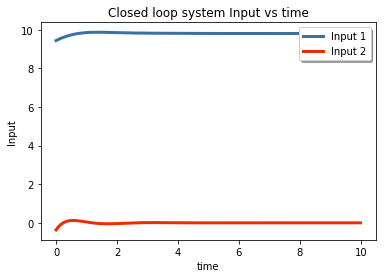

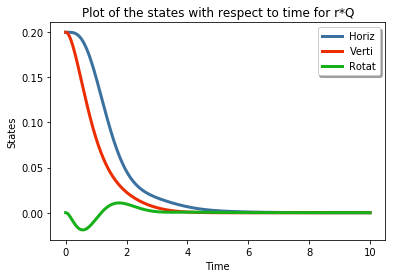

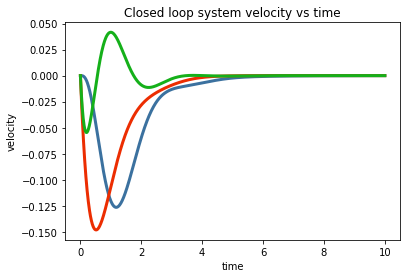

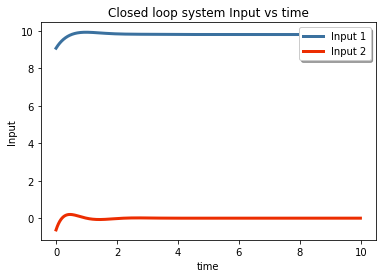

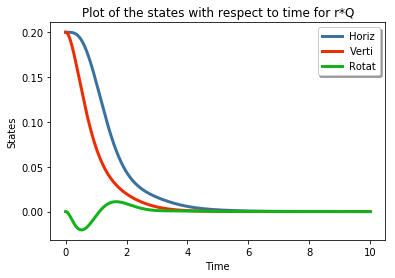

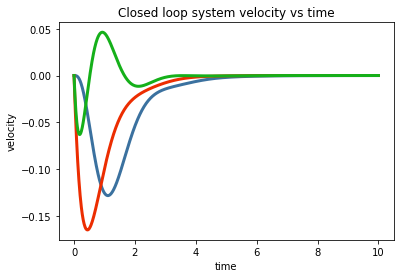

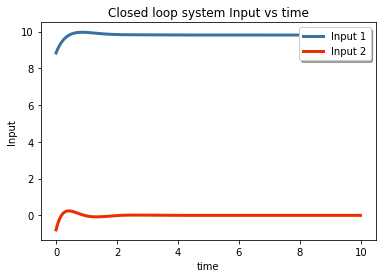

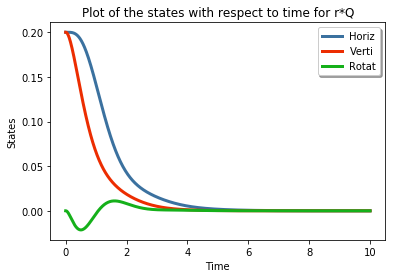

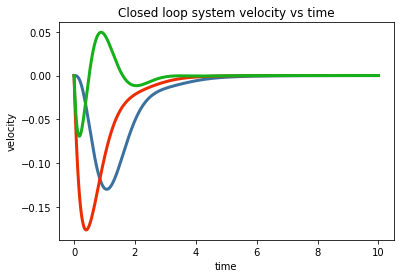

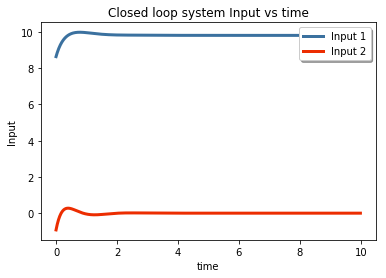

In [10]:
# generate random positive matrix
def generate_random_posdef(size):
    temp = scipy.random.rand(size,size)
    B = np.dot(temp,temp.transpose())
    return B+np.identity(size)

def LQRscheme(A,Q,R,B,t0,t,dt):
    steps= np.arange(t0,t,dt)
    P = Q
    finalP=[]
    finalK=[]
    count1=0
    for i in steps:
        
        dp= P +dt*(np.dot(A.transpose(),P)+np.dot(P,A)- np.dot(P,np.dot(B,np.dot(LA.inv(R),np.dot(B.transpose(),P))))+Q)
        P=dp
        finalP.append(dp)
        count1+=1
    count=0
    
    for i in steps:
        finalK.append(np.dot(LA.inv(R),np.dot(B.transpose(),np.array(finalP[count1-count-1]))))
        count+=1
    return np.asarray(finalK), np.asarray(finalP)
Q1= generate_random_posdef(A.shape[0])
R= generate_random_posdef(2)
for r in np.arange(1,10,2.5):    
    Q=r*Q1
    #R=np.identity(2)
    t0,t,dt=0,10,0.01
    lqrk,lqrP= LQRscheme(A,Q,R,B,t0,t,dt)

    # for compare
    def tvCTLQR(A,B,Q,R,Pt,tf,dt=dt):
        t_ = 0.0
        K = []
        P = []
        while t_ < tf:
            P_ = scipy.linalg.solve_continuous_are(A,B,Q,R)
            K_ = np.dot(LA.inv(R), np.dot(B.T,P_))
            K.append(K_)
            P.append(P_)
            t_ += dt
        K_ = np.dot(LA.inv(R), np.dot(B.T,Pt))
        K.append(K_)
        P.append(Pt)
        return np.asarray(K),np.asarray(P)
    lqrKac,lqrPac=tvCTLQR(A,B,Q,R,t0,t,dt)
    #print("lqrKac",lqrKac[502,:,:])
    #print("lqrk",lqrk[500,:,:])
    #fig,ax=plt.subplots()
    #ax.plot(np.arange(t0,t,dt),lqrk[:,0,6])
    #plt.show()
    #print('lqrk',lqrk[490:500,:,:],'lqrKac',lqrKac[490:502,:,:])


    def u(t,x):
        dt=0.01
        s=np.dot(-lqrKac[int(t/dt),:,:],x)
        return s+[m*g,0]
    def simulatex(r):
        t0,x0,t,dt=0,np.array([0.2,0.2,0,0,0,0]),10,0.01
        T,x,uout= forward_euler(f,t,x0,t0,dt,utx=u,return_u= True)
        cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]
        fig, ax = plt.subplots()
        ax.plot(T,x[:,0],c=cols[0],label='Horiz',linewidth=3)
        ax.plot(T,x[:,1],c=cols[1],label='Verti',linewidth=3)
        ax.plot(T,x[:,2],c=cols[2],label='Rotat',linewidth=3)
        legend = ax.legend(loc='upper right', shadow=True)
        plt.title('Plot of the states with respect to time for r*Q')
        plt.xlabel('Time')
        plt.ylabel('States')
        plt.show()
         
        fig, ax2 = plt.subplots()
        ax2.plot(T,x[:,3],c=cols[0],label='Horiz',linewidth=3)
        ax2.plot(T,x[:,4],c=cols[1],label='Verti',linewidth=3)
        ax2.plot(T,x[:,5],c=cols[2],label='Rotat',linewidth=3)
        plt.title('Closed loop system velocity vs time')
        plt.xlabel('time')
        plt.ylabel('velocity')
        plt.show()

        fig, ax3 = plt.subplots()
        ax3.plot(T[0:1000],uout[:,0],c=cols[0],label='Input 1',linewidth=3)
        ax3.plot(T[0:1000],uout[:,1],c=cols[1],label='Input 2',linewidth=3)
        plt.title('Closed loop system Input vs time')
        plt.xlabel('time')
        plt.ylabel('Input')

        legend = ax3.legend(loc='upper right', shadow=True)
        plt.show()
        return 1
    a=simulatex(r)    
    
    

#### (b) 3
Use that function from (a.1) to randomly generate different Q, R matrices and use the implementation in (a.2) to find an optimal controller for the quadrotor. Implement the optimal control on the nonlinear quadrotor and provide plots of the position, velocity and input as before.  

Again, animation will help you visualize what is happening. 

Compare the optimal controller performance to the stabilizing feedback performance. What happens as you vary Q and R? Can you generate a Q and R that give you similar performance as the stabilizing feedback controller?

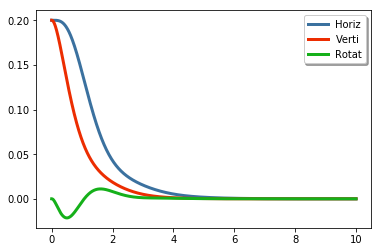

In [12]:

def u(t,x):
    dt=0.01
    s=np.dot(-lqrk[int(t/dt),:,:],x)
    return s+[m*g,0]
def simulatex():
    t0,x0,t,dt=0,np.array([0.2,0.2,0,0,0,0]),10,0.01
    T,x= forward_euler(f,t,x0,t0,dt,utx=u)
    cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]
    fig, ax = plt.subplots()
    ax.plot(T,x[:,0],c=cols[0],label='Horiz',linewidth=3)
    ax.plot(T,x[:,1],c=cols[1],label='Verti',linewidth=3)
    ax.plot(T,x[:,2],c=cols[2],label='Rotat',linewidth=3)
    legend = ax.legend(loc='upper right', shadow=True)
    plt.show()
    return 1
# def forwardeuler(t0,t,f,x0,dt,u):
#     steps= np.arange(t0,t,dt)
#     n=x0.shape
#     xout=[]
#     #xout= np.zeros((int(n[0]),int(t/dt)))
#     for i in steps:
#         #print(x0,u)]
#         #print(K,'u',u)
#         u=np.dot(-lqrk[int(i/dt),:,:],x0)+[m*g,0]
#         out= x0 + dt*f(i,x0,u)
#         xout.append(out)
#         x0=out
#         #print(out)
#     return steps, xout
a=simulatex()
# other method
# t0,x0,t,dt,u=0,np.array([0.2,0.2,0,0,0,0]),20,0.01,[0,0]
# tout,xout= forwardeuler(t0,t,f,x0,dt,u)
# cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green']]
# fig, ax = plt.subplots()
# arrayx=np.array(xout)
# ax.plot(tout,arrayx[:,0],c=cols[0],label='Horiz',linewidth=3)
# ax.plot(tout,arrayx[:,1],c=cols[1],label='Verti',linewidth=3)
# ax.plot(tout,arrayx[:,2],c=cols[2],label='Rotat',linewidth=3)
# legend = ax.legend(loc='upper right', shadow=True)
# plt.show()


The controller her is faster in response if the value of Q increases moreover if the value of R decresases then the controller is slower in response.

## Part 4 KF on Closed Loop Linearized System
In this part you will implement a discrete time KF on the closed loop linearized system. Linearize your dynamics as in part 1. Take a stabilizing controller and create the closed loop linerized system which is an approximation of the non-linear dynamics in a neighborhood of $x_0,u_0$ around which we linearized.

In each of the steps where you implement the KF on your system, provide commentary on what you observe. What can you say about the performance as you vary the noise?
#### (a)
Discretize the stable closed loop system to create a DT difference equation
$$ x_{t+1}=A_{\text{cl},d}x_t$$

#### (b)  Consider a noisy version of this system
$$\begin{array}{ll}x_{t+1}&=A_{\text{cl},d}x_t+F_tw_t\\
y_t&=C_dx_t+H_tv_t\end{array}$$
Generate noisy samples of the discrete time system where $\mathbb{E}[w_tw_t^T]=W$, $\mathbb{E}[v_tv_t^T]=V$, $\mathbb{E}[x_0]=\bar{x}_0$ and $\mathbb{E}[(x_0-\bar{x}_0)(x_0-\bar{x}_0)^T]=\Sigma_0$. Start with 
$v_t\sim \mathcal{N}(0,0.2I_{2\times 2})$ and $w_t\sim \mathcal{N}(0,0.1I_{2\times 2})$, $\Sigma_0=\text{diag}(0.1, 0.1, 0.1, 0.1, 0.1, 0.1)$. Let $F_t$ be the discretized control dynamics $B_d$ and $H_t=I$.


#### (c) 
Implement the discrete time Kalman filter. You must do this your self, not using any off-the shelf tools.

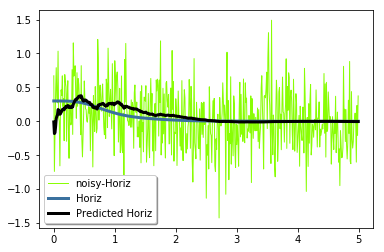

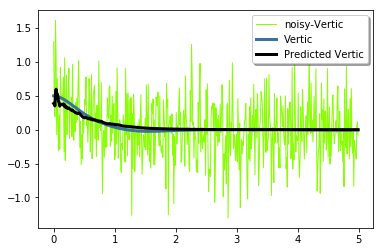

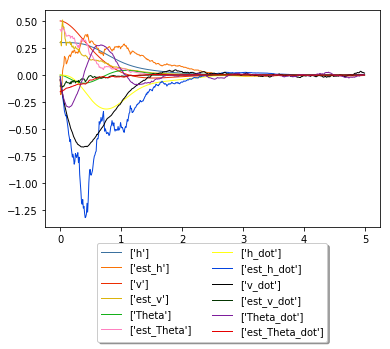

In [1]:

import sys
sys.modules[__name__].__dict__.clear()
from _547 import forward_euler
import matplotlib.pyplot as plt
import math
import numpy as np
from seaborn import xkcd_rgb as xkcd
from matplotlib import animation, rc
from numpy import linalg as LA
import control
import scipy
import copy
from matplotlib.font_manager import FontProperties


m,g,I=1,9.81,1
A = np.array([[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[0,0,g,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
B = np.array([[0,0],[0,0],[0,0],[0,0],[1,0],[0,1]])
def f(t,x,u):
    # positions, velocities
    # horiz., vert., rotation
    # thrust, torque
    vector= np.asarray([x[3],x[4],x[5],(u[0]/m)*math.sin(x[2]),(-g+(u[0]/m)*math.cos(x[2])),u[1]/I])
    return vector# returning the vecotr of the functions given in the question
def f_lin(t,x,u): #function if linearized dynamics
    A=np.asarray([[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[0,0,m*g/m,0,0,0],[0,0,-m*g/m*x[2],0,0,0],[0,0,0,0,0,0]])
    B=np.asarray([[0,0],[0,0],[0,0],[x[2]/m,0],[1/m,0],[0,1/I]])
    return np.dot(A,x)+np.dot(B,u)
def find_k(A,B):    
    la=2
    n,m= A.shape
    newA= -la*np.identity(n)-A
    # check if stable
 
    W= np.array(scipy.linalg.solve_lyapunov(newA,np.dot(B,B.transpose())))
    #print(W)
    P=LA.inv(W)
    #print(P)
    K= -1/2*np.dot(np.transpose(B),P)
    p,r=K.shape
    Kvalue=np.zeros((p,r))
    for i in range(p):
        for j in range(r):
            Kvalue[i,j]= float(K[i,j])
    return Kvalue,newA

K,newA= find_k(A,B)
t0,t,dt=0,5,0.01
Kss=K
t_=np.arange(t0,t,dt)

#print(Kss)
NewA=A-np.dot(B,Kss)
Ad = scipy.linalg.expm(newA*dt)
Bd = np.dot(LA.inv(newA),np.dot((Ad-np.identity(Ad.shape[0])),B))
Q,R,P0,H,u1 =0.1*np.identity(2),0.2*np.identity(2),0.1*np.identity(A.shape[0]),np.identity(2),np.array([0,0])
x0=np.random.multivariate_normal(np.array([0,0,0,0,0,0]),P0)
# starting point of filter
def kalman_filter(x0,P0,Adis,Bdis,Ks,Q,H,R,t_,dt,f,u,A,B):
      
    F,C,x0p =Bdis,np.array([[1,0,0,0,0,0],[0,1,0.2,0,0,0]]),np.array([0.3,0.5,0,0,0,0]) #startig point of equation
    savey,savex,saveybar,savexbar,say=[],[],[],[],[]
    for i in t_:
        u1=-np.dot(Ks,x0p)#+[m*g,0]
        xt= x0p + dt*(f_lin(i,x0p,u1))+np.dot(F,np.random.multivariate_normal([0,0],Q))# the main equation 1
        yt1= np.dot(C,xt)
        yt= np.dot(C,xt) +np.dot(H,np.random.multivariate_normal([0,0],R))# the main equauation 2
 
        barx= np.dot(Adis,x0)
        #print('barx',barx)
        Pbar= np.dot(Adis,np.dot(P0,Adis.transpose())) + np.dot(F,np.dot(Q,F.transpose()))
        #rint('Pbar',Pbar)
        L1= LA.inv(np.dot(C,np.dot(Pbar,C.transpose()))+np.dot(H,np.dot(R,H.transpose())))
        L2= np.dot(Adis,np.dot(Pbar,C.transpose()))
        L= np.dot(L2,L1)
        barx1= barx + np.dot(L,(yt-np.dot(C,barx)))
        Pbar1=  Pbar-np.dot(np.dot(L,C),Pbar)
        x0= copy.deepcopy(barx1)
        P0= copy.deepcopy(Pbar1)
        #print(L)
        #print('xt',xt)
        x0p= copy.deepcopy(xt)
        say.append(yt1)
        savey.append(yt)
        savex.append(xt)
        saveybar.append(np.dot(C,barx1))
        savexbar.append(barx1)
    cols=[xkcd['muted blue'],xkcd['tomato red'],xkcd['green'],xkcd['yellow'],xkcd['black'],xkcd['purple']]
    est_cols=[xkcd['orange'],xkcd['gold'],xkcd['pink'],xkcd['blue'],xkcd['dark green'],xkcd['red']]
    lab = [['h'],['v'],['Theta'],['h_dot'],['v_dot'],['Theta_dot']]
    est_lab = [['est_h'],['est_v'],['est_Theta'],['est_h_dot'],['est_v_dot'],['est_Theta_dot']]
    fig, ax = plt.subplots()
    fig, ax1 = plt.subplots()
    fig, ax2 = plt.subplots()


    say=np.array(say)
    savex=np.array(savex)
    savey= np.array(savey)
    savexbar= np.array(savexbar)
    saveybar= np.array(saveybar)
    
    
    ax.plot(t_,savey[:,0],c=xkcd['lime green'],label='noisy-Horiz',linewidth=1)
    ax.plot(t_,say[:,0],c=cols[0],label='Horiz',linewidth=3)    
    ax.plot(t_,saveybar[:,0],c=xkcd['black'],label='Predicted Horiz',linewidth=3)
    
    ax1.plot(t_,savey[:,1],c=xkcd['lime green'],label='noisy-Vertic',linewidth=1)
    ax1.plot(t_,say[:,1],c=cols[0],label='Vertic',linewidth=3)
    ax1.plot(t_,saveybar[:,1],c=xkcd['black'],label='Predicted Vertic',linewidth=3)
    
    for i in range(6):
        ax2.plot(t_,savex[:,i],c=cols[i],label=(str(lab[i])),linewidth=1)
        ax2.plot(t_,savexbar[:,i],c=est_cols[i],label=(str(est_lab[i])),linewidth=1)
    #ax.plot(tout,arrayx[:,1],c=cols[1],label='Verti',linewidth=3)
    #ax.plot(tout,arrayx[:,2],c=cols[2],label='Rotat',linewidth=3)
    legend = ax.legend(loc='best', shadow=True)
    legend = ax1.legend(loc='best', shadow=True)
    #legend = ax2.legend(loc='best', shadow=True)
    legend = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
    plt.show()

    
kalman_filter(x0,P0,Ad,Bd,Kss,Q,H,R,t_,dt,f,u1,A,B)


#### (d) Apply the kalman filter to your system. 
Test first with the above noise statistics.  Plot the $y$'s you generated (i.e. $y_t=Cx_t$ where $x_{t}=A_{\text{cl}}x_{t-1}+F_tw_t$), the noisy $y$'s (i.e. $y_t=Cx_t+H_tv_t$) and the KF estimates of $y_t$. On another figure, plot also the KF estimated $x$'s and the noisy samples of $x$. 

Now use the PSD function to test other randomly generate $\Sigma_0$'s and test other distributions for $v_t$ and $w_t$. Compare the performance.

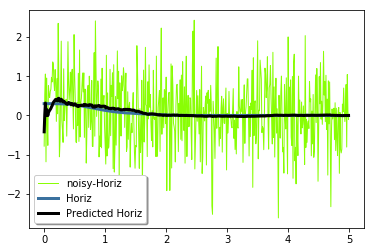

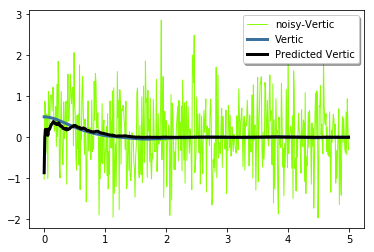

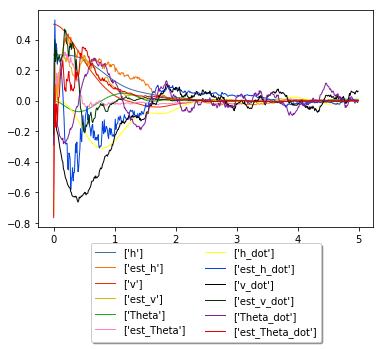

In [2]:
def generate_random_posdef(size):
    temp = scipy.random.rand(size,size)
    B = np.dot(temp,temp.transpose())
    return B
Q,R,P0,H,u1 =generate_random_posdef(2),generate_random_posdef(2),generate_random_posdef(A.shape[0]),np.identity(2),np.array([0,0])
x0=np.random.multivariate_normal(np.array([0,0,0,0,0,0]),P0)
kalman_filter(x0,P0,Ad,Bd,Kss,Q,H,R,t_,dt,f,u1,A,B)